# Gradient Boosting Model inital attempt

In [241]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [242]:
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score

In [243]:
df= pd.read_parquet("final_data.parquet")
df

,constructorId,constructor_name,constructorStandingsId,raceId_x,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,Points_Per_Entry,Years_Active,Champion,driverRef,code,driverStandingsId,raceId_y,points,position,driver_wins
0,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,4,18,5.0,4,0
1,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,12,19,6.0,7,0
2,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,30,20,6.0,9,0
3,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,51,21,6.0,10,0
4,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,5.78273,19,True,alonso,ALO,72,22,9.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355645,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73126,1140,9.0,16,0
355646,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73172,1141,26.0,12,0
355647,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73218,1142,26.0,12,0
355648,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,3.06422,6,False,gasly,GAS,73241,1143,36.0,11,0


In [244]:
#create binary variable for classifier
df['win']= (df['position']== 1).astype(int)

#features to keep for driver win predictions
features= [
    'grid', 'laps', 'results_points', 'fastestLapSpeed',  #race and performance info
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed',  #weather/track conditions
    'Race_Entries', 'Race_Starts', 'Pole_Positions', 'Race_Wins', 'Podiums', #rest is for driver performance
    'Fastest_Laps', 'Points', 'Pole_Rate', 'Start_Rate', 'Win_Rate', 'Podium_Rate',
    'FastLap_Rate', 'Points_Per_Entry', 'Years_Active'
]

#convert to numerical
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#only use rows will full data
df= df.dropna(subset=features+ ['win']+ ['race_name']+ ['constructor_name']+ ['constructorId'])

X= df[features]
y= df['win']

In [245]:
#Kfold cross validation
kf= StratifiedKFold(n_splits=5, shuffle=True)

#fold metrics
f_accuracy=[]
f_auc= []
f_precision= []
f_recall=[]
f_f1=[]

#lists for all kfold predictions and things
f_indicies=[]
f_predictions=[]
f_probs=[]

In [246]:
#Perform cross-validation
#followed a guide for this

win_ratio = y.mean() #win ratio for a better base_score for model

for fold, (train, test) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}/{kf.n_splits}")
    
    X_train_fold, X_test_fold= X.iloc[train], X.iloc[test]
    y_train_fold, y_test_fold= y.iloc[train], y.iloc[test]
    
    model= xgb.XGBClassifier(eval_metric='logloss', base_score=win_ratio,
                             learning_rate=0.5, n_estimators=100, max_depth=3,
                             subsample=0.8, colsample_bytree=0.8, scale_pos_weight=3)
    
    model.fit(X_train_fold, y_train_fold)
    
    #predict
    xgbYPred= model.predict(X_test_fold)
    #trying a threshold instead
    # threshold= 0.3
    xgbYPred_probability= model.predict_proba(X_test_fold)[:, 1]
    # xgbYPred= (xgbYPred_probability > threshold).astype(int)
    
    #save predictions (extend not append)
    f_indicies.extend(test)
    f_predictions.extend(xgbYPred)
    f_probs.extend(xgbYPred_probability)
    
    acc= accuracy_score(y_test_fold, xgbYPred)
    auc= roc_auc_score(y_test_fold, xgbYPred_probability)
    report= classification_report(y_test_fold, xgbYPred, output_dict=True)
    
    #store for the overall metric
    f_accuracy.append(acc)
    f_auc.append(auc)
    
    #store precision, recall, and f1 for race win (1)
    f_precision.append(report['1']['precision'])
    f_recall.append(report['1']['recall'])
    f_f1.append(report['1']['f1-score'])
    
    #fold metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_fold, xgbYPred))


Fold 1/5
Accuracy: 0.8532
AUC: 0.8951
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     60008
           1       0.35      0.81      0.49      5811

    accuracy                           0.85     65819
   macro avg       0.67      0.83      0.70     65819
weighted avg       0.92      0.85      0.88     65819


Fold 2/5
Accuracy: 0.8577
AUC: 0.8991
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     60008
           1       0.36      0.81      0.50      5811

    accuracy                           0.86     65819
   macro avg       0.67      0.84      0.71     65819
weighted avg       0.92      0.86      0.88     65819


Fold 3/5
Accuracy: 0.8559
AUC: 0.8987
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     60007
           1       0.36      0.81      0.50      58

In [247]:
#overall metrics
print("\n--- Overall Cross-Validation Results ---")
print(f"Mean Accuracy: {np.mean(f_accuracy):.4f}")
print(f"Mean AUC: {np.mean(f_auc):.4f}")
print(f"Mean Precision (wins): {np.mean(f_precision):.4f}")
print(f"Mean Recall (wins): {np.mean(f_recall):.4f}")
print(f"Mean F1 (wins): {np.mean(f_f1):.4f}")


--- Overall Cross-Validation Results ---
Mean Accuracy: 0.8555
Mean AUC: 0.8978
Mean Precision (wins): 0.3592
Mean Recall (wins): 0.8121
Mean F1 (wins): 0.4981


In [248]:
def plot_kfold_visualization(X, y, kf):
    fig, axes = plt.subplots(kf.n_splits, 1, figsize=(10, 6), sharex=True)
    fig.suptitle('5-Fold Cross-Validation Visualization', fontsize=16)
    
    # Create a binary mask for each fold
    all_indices = np.arange(len(X))
    cmap = plt.cm.tab10
    
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        train_mask = np.zeros(len(X), dtype=bool)
        test_mask = np.zeros(len(X), dtype=bool)
        train_mask[train_idx] = True
        test_mask[test_idx] = True
        
        axes[i].scatter(all_indices[train_mask], [i+0.1]*sum(train_mask), 
                      c='blue', s=10, alpha=0.5, label='Training')
        axes[i].scatter(all_indices[test_mask], [i+0.2]*sum(test_mask), 
                      c='red', s=10, alpha=0.7, label='Testing')
        axes[i].set_ylabel(f'Fold {i+1}')
        
    # Remove x ticks for clarity
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.xlabel('Data points')
    
    # Add legend to the first subplot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [249]:
def plot_metrics_by_fold():
    metrics = {
        'Accuracy': f_accuracy,
        'AUC': f_auc,
        'Precision': f_precision,
        'Recall': f_recall,
        'F1': f_f1
    }
    
    folds = [f'Fold {i+1}' for i in range(len(f_accuracy))]
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(folds))
    width = 0.15
    multiplier = 0
    
    for metric_name, metric_values in metrics.items():
        offset = width * multiplier
        plt.bar(x + offset, metric_values, width, label=metric_name)
        multiplier += 1
    
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title('Metrics by Fold')
    plt.xticks(x + width * 2, folds)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

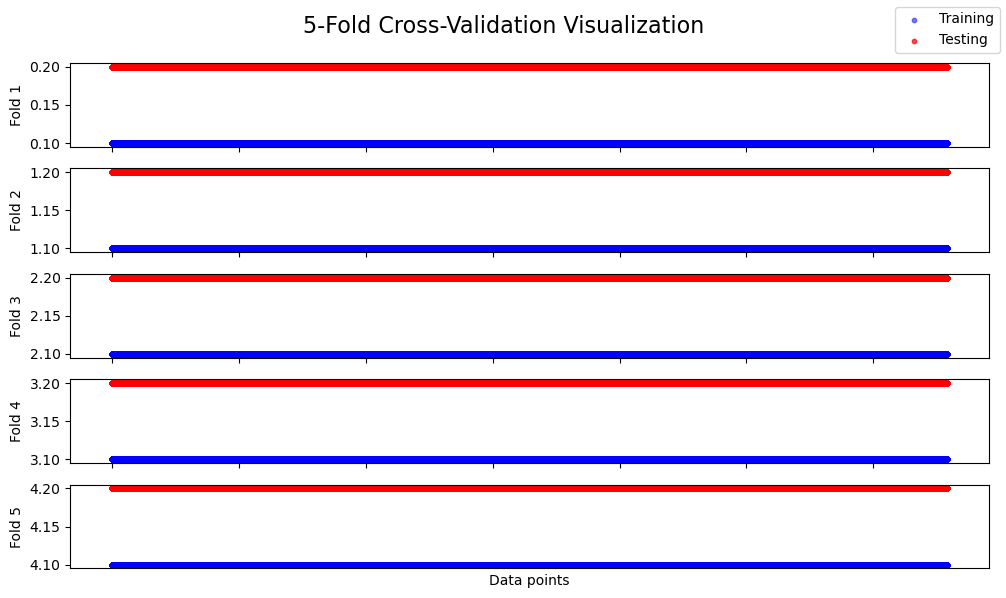

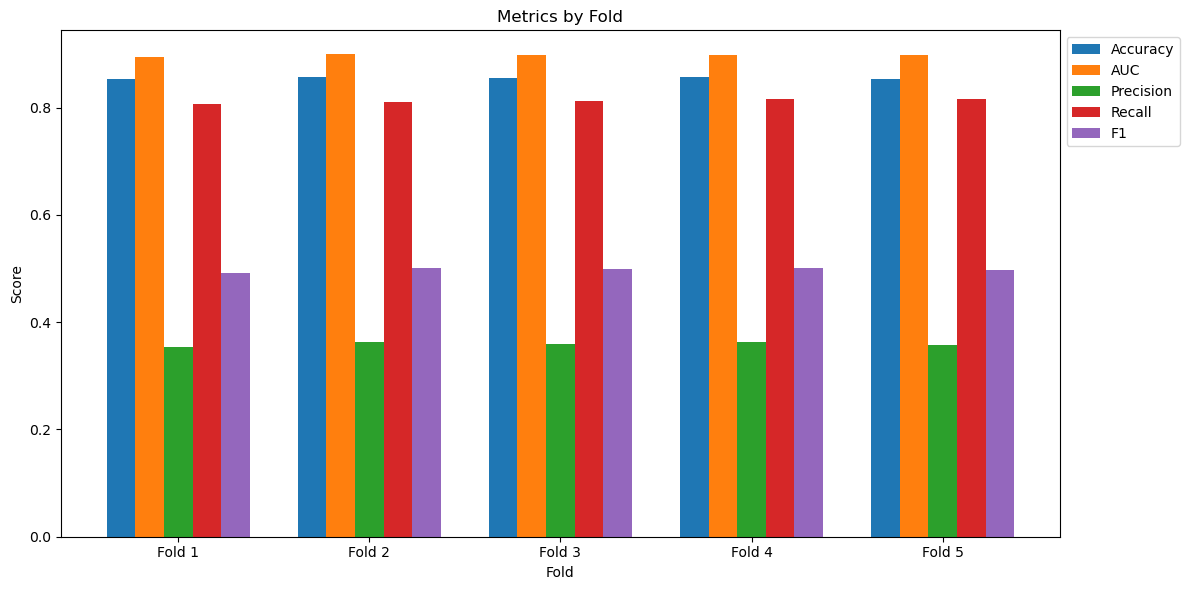

In [250]:
plot_kfold_visualization(X, y, kf)
plot_metrics_by_fold()

In [251]:
def plot_feature_importance(model, features):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(importance)), importance[indices], align='center')
    plt.xticks(range(len(importance)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

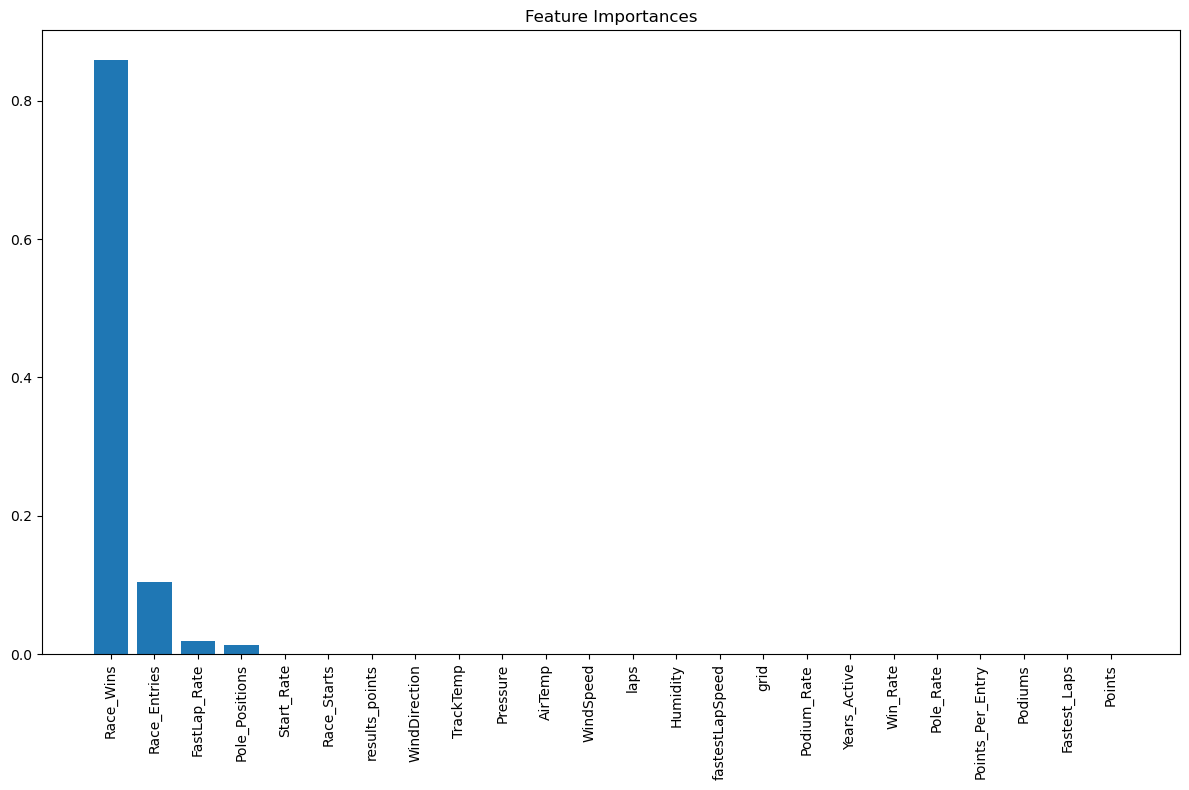

In [252]:
plot_feature_importance(model, features)

In [253]:
#make the race_winners dataframe

#make the lsits into numpy arrays to make next step easier
f_indicies = np.array(f_indicies)
f_predictions = np.array(f_predictions)
f_probs = np.array(f_probs)

race_winners = df.iloc[f_indicies].copy()
race_winners['predicted_winner'] = f_predictions
race_winners['predicted_winner_prob'] = f_probs

In [254]:
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state= 33)

In [255]:
# model= xgb.XGBClassifier(eval_metric='logloss', random_state=22, base_score= 0.5,
#                          learning_rate= 0.1, n_estimators= 100, max_depth= 3,
#                          subsample= 0.8, colsample_bytree= 0.8)

In [256]:
# model.fit(X_train, y_train)

In [257]:
# xgbYPred= model.predict(X_test)
# xgbYPred_probability= model.predict_proba(X_test)[:, 1]

In [258]:
# print("Accuracy: ", accuracy_score(y_test, xgbYPred))
# print("AUC Score: ", roc_auc_score(y_test, xgbYPred_probability))
# print("\nClassification Report \n", classification_report(y_test, xgbYPred))

In [259]:
#Putting predictions in the dataframe
# race_winners= df.loc[X_test.index].copy()
# race_winners['predicted_winner']= xgbYPred
# race_winners['predicted_winner_probability']= xgbYPred_probability

In [260]:
#get the names of all the races
unique_race_names = df['race_name'].unique()
print(unique_race_names)

['Australian Grand Prix' 'Bahrain Grand Prix' 'Chinese Grand Prix'
 'Azerbaijan Grand Prix' 'Spanish Grand Prix' 'Monaco Grand Prix'
 'Canadian Grand Prix' 'French Grand Prix' 'Austrian Grand Prix'
 'British Grand Prix' 'German Grand Prix' 'Hungarian Grand Prix'
 'Italian Grand Prix' 'Singapore Grand Prix' 'Russian Grand Prix'
 'Japanese Grand Prix' 'United States Grand Prix' 'Mexican Grand Prix'
 'Brazilian Grand Prix' 'Abu Dhabi Grand Prix' 'Belgian Grand Prix'
 'Tuscan Grand Prix' 'Eifel Grand Prix' 'Portuguese Grand Prix'
 'Emilia Romagna Grand Prix' 'Turkish Grand Prix' 'Qatar Grand Prix'
 'Styrian Grand Prix' 'Dutch Grand Prix' 'Mexico City Grand Prix'
 'São Paulo Grand Prix' 'Saudi Arabian Grand Prix' 'Miami Grand Prix'
 'Las Vegas Grand Prix']


In [261]:
def get_driver_prediction(race_name):
        filtered= race_winners[race_winners['race_name'] == race_name]
        
        if len(filtered) == 0:
            return f"No data for race: {race_name}"

        filtered= filtered.drop_duplicates(subset=['driverId'])

        #normalize so it all adds up to 100%
        total_prob = filtered['predicted_winner_prob'].sum()
        filtered['normalized_prob'] = filtered['predicted_winner_prob'] / total_prob
        
        return filtered.sort_values('normalized_prob', ascending=False)

In [262]:
def get_constructor_prediction(race_name):
    #get driver predictions
    filtered= get_driver_prediction(race_name)
    
    constructor_predictions = filtered.groupby('constructorId').agg({
        'normalized_prob': 'sum',
        'constructor_name': 'first'  # Assuming this column exists
    }).reset_index()
    
    # Sort by probability
    return constructor_predictions.sort_values('normalized_prob', ascending=False)

In [263]:
country= "Dutch"
race= f"{country} Grand Prix"
race_pred= get_driver_prediction(race)
constructor_pred= get_constructor_prediction(race)

# print(f"\nPredictions for {race}:")
# print(race_pred[['forename', 'surname', 'predicted_winner_probability']].head(10))

#looked online for how to make it look nicer
print(f"\n--- Predictions for {race} ---")
print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
print("-" * 50)

for i, (_, row) in enumerate(race_pred.head(5).iterrows(), 1):
    driver_name = f"{row['forename']} {row['surname']}"
    probability = f"{row['normalized_prob']*100:.2f}%"
    print(f"{i:<8} {driver_name:<25} {probability:<15}")

#no lie i stole this code just so it looks nice. Please dont judge me

# #did it for constructors too
# print(f"\n--- Constructor Predictions for {race} ---")
# print(f"{'Position':<8} {'Constructor':<25} {'Win Probability':<15}")
# print("-" * 50)

# for i, (_, row) in enumerate(constructor_pred.head(5).iterrows(), 1):
#     constructor = row['constructor_name']
#     probability = f"{row['normalized_prob']*100:.2f}%"
#     print(f"{i:<8} {constructor:<25} {probability:<15}")


--- Predictions for Dutch Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Max Verstappen            38.78%         
2        Lewis Hamilton            37.95%         
3        Fernando Alonso           15.44%         
4        Charles Leclerc           5.17%          
5        Valtteri Bottas           2.65%          
